In [1]:
import pandas as pd
import numpy as np
import math

In [2]:
# Define Heat Index Equations

# I wrote this one from the NOAA documentation
def get_heat_index_SLS(T, RH):
    # Calculate according to NOAA simple HI eqn
    simple_HI = 0.5 * (T + 61.0 + ((T - 68.0) * 1.2) + (RH * 0.094))
    
    # If HI < 80, the simple eqn is enough
    if simple_HI < 80:
        print(f'     HI {simple_HI} is < 80; simple eq. used')
        return simple_HI
    
    # Else, run thru Rothfusz Regression
    else: 
        print(f'     *** HI {simple_HI} is > 80; Rothfusz Regression used')
        HI = (-42.379 
              + 2.04901523 * T 
              + 10.14333127 * RH 
              - 0.22475541 * T * RH 
              - 0.00683783 * T ** 2 
              - 0.05481717 * RH ** 2 
              + 0.00122874 * T ** 2 * RH 
              + 0.00085282 * T * RH ** 2 
              - 0.00000199 * T ** 2 * RH ** 2)

        # Adjustment if RH < 13% and 80°F <= T <= 112°F
        if RH < 13 and 80 <= T <= 112:
            print(f'      *** RH [{RH}] < 13% and 80°F <= T [{T}] <= 112°F; Adjustment 1 used!')
            adjustment = ((13 - RH) / 4) * math.sqrt((17 - abs(T - 95.0)) / 17)
            HI -= adjustment

        # Adjustment if RH > 85% and 80°F <= T <= 87°F
        elif RH > 85 and 80 <= T <= 87:
            print(f'      *** RH [{RH}] > 85% and 80°F <= T [{T}] <= 87°F; Adjustment 1 used!')
            adjustment = ((RH - 85) / 10) * ((87 - T) / 5)
            HI += adjustment
        return HI

# This one was retrieved from github
def get_heat_index_GITHUB(t, rh):
    '''
    Calculate heat index

    Rothfusz LP. 1990. The Heat Index Equation, SR Technical Attachment, 94-19, pp 6.
    http://www.hpc.ncep.noaa.gov/html/heatindex_equation.shtml

    :param array t: drybulb temperature (deg C)
    :param array rh: relative humidity (%)

    :returns array heat_index: heat index (deg C)

    NOTE: This gives meaning less results when t < 26.6 oC and rh < 40%
    '''

    t_fahrenheit = t * (9./5.) + 32

    heat_index_fahrenheit = -42.379 + (2.04901523 * t_fahrenheit) + (10.14333127 * rh) + \
        (-0.22475541 * t_fahrenheit * rh) + (-0.006837837 * t_fahrenheit * t_fahrenheit) + \
        (-0.05481717 * rh * rh) + (0.001228747 * t_fahrenheit * t_fahrenheit * rh) + \
        (0.00085282 * t_fahrenheit * rh * rh) + (-0.00000199 * t_fahrenheit * t_fahrenheit * rh * rh)

    # apply adjustment factors
    locs = np.ma.where(np.ma.logical_and((rh < 13), (t_fahrenheit > 80), (t_fahrenheit < 112)))
    if len(locs[0]) > 0:
        heat_index_fahrenheit[locs] = heat_index_fahrenheit[locs] - (((13.- rh[locs]) / 4.) * np.ma.sqrt((17. - np.ma.abs(t_fahrenheit[locs] - 95.)) / 17.)) 


    locs = np.ma.where(np.ma.logical_and((rh > 85), (t_fahrenheit > 80), (t_fahrenheit < 87)))
    if len(locs[0]) > 0:
        heat_index_fahrenheit[locs] = heat_index_fahrenheit[locs] - (((rh[locs ] - 85) / 10.) * ((87. - t_fahrenheit[locs]) / 5.))
    
    locs = np.ma.where(heat_index_fahrenheit < 80)
    if len(locs[0]) > 0:
        heat_index_fahrenheit[locs] = 0.5 * (t_fahrenheit[locs] + 61. + ((t_fahrenheit[locs] - 68.) * 1.2) + (rh[locs] * 0.094))
 
    heat_index = (heat_index_fahrenheit - 32) / (9./5.)

    locs = np.ma.where(t < 26.6667) # 80F
    if len(locs[0]) > 0:
        heat_index[locs] = -99
    locs = np.ma.where(rh < 40.0)
    if len(locs[0]) > 0:
        heat_index[locs] = -99
 

    '''
    FURTHER NOTES:

The computation of the heat index is a refinement of a result obtained by multiple regression analysis carried out by Lans P. Rothfusz and described in a 1990 National Weather Service (NWS) Technical Attachment (SR 90-23).  The regression equation of Rothfusz is

HI = -42.379 + 2.04901523*T + 10.14333127*RH - .22475541*T*RH - .00683783*T*T - .05481717*RH*RH + .00122874*T*T*RH + .00085282*T*RH*RH - .00000199*T*T*RH*RH 

where T is temperature in degrees F and RH is relative humidity in percent.  HI is the heat index expressed as an apparent temperature in degrees F.  If the RH is less than 13% and the temperature is between 80 and 112 degrees F, then the following adjustment is subtracted from HI:

ADJUSTMENT = [(13-RH)/4]*SQRT{[17-ABS(T-95.)]/17} 

where ABS and SQRT are the absolute value and square root functions, respectively.  On the other hand, if the RH is greater than 85% and the temperature is between 80 and 87 degrees F, then the following adjustment is added to HI:

ADJUSTMENT = [(RH-85)/10] * [(87-T)/5] 

The Rothfusz regression is not appropriate when conditions of temperature and humidity warrant a heat index value below about 80 degrees F. In those cases, a simpler formula is applied to calculate values consistent with Steadman's results:

HI = 0.5 * {T + 61.0 + [(T-68.0)*1.2] + (RH*0.094)} 

In practice, the simple formula is computed first and the result averaged with the temperature. If this heat index value is 80 degrees F or higher, the full regression equation along with any adjustment as described above is applied.

The Rothfusz regression is not valid for extreme temperature and relative humidity conditions beyond the range of data considered by Steadman. '''

    return heat_index # calculate_heat_index

In [3]:
# Open up your CSV
fn = 'Downloads/College Park Airport 2007-2024 TMAX RH.csv' #Replace with path to your file
#fn = (f'C:/Users/kcstover/Documents/Python Scripts/College Park Airport 2007-2024 TMAX RH.csv')
df = pd.read_csv(fn, skiprows=2) # Open in pandas 

# Format the date as datetime
df['DATE'] = pd.to_datetime(df['DATE'])

# Quicklook at the data
df.head()

C:\Users\slsmit34\AppData\Local\Temp\1\ipykernel_38928\2922704608.py:4: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(fn, skiprows=2) # Open in pandas


,DATE,HourlyDryBulbTemperature,HourlyRelativeHumidity,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Time
0,2007-06-01,75.0,69.0,6/1/2007,90.0,45.33,90.42,92.622778,92.62,NaN,0:00:00
1,2007-06-01,73.0,74.0,6/2/2007,90.0,46.00,90.43,92.890418,92.89,NaN,0:25:00
2,2007-06-01,73.0,74.0,6/3/2007,75.0,78.00,75.43,NaN,75.43,NaN,0:45:00
3,2007-06-01,73.0,74.0,6/4/2007,82.0,66.00,82.50,85.591715,85.59,NaN,1:05:00
4,2007-06-01,73.0,74.0,6/5/2007,82.0,NaN,80.95,79.662680,79.66,NaN,1:30:00


In [4]:
# Make a date range for our loop
startDate = df.iloc[0]['DATE']
endDate = df.iloc[-1]['DATE']

#The date range
date_range = pd.date_range(start=startDate, end=endDate)
print('Date Range:')
for date in date_range: print(date.date())

Date Range:
2007-06-01
2007-06-02
2007-06-03
2007-06-04
2007-06-05
2007-06-06
2007-06-07
2007-06-08
2007-06-09
2007-06-10
2007-06-11
2007-06-12
2007-06-13
2007-06-14
2007-06-15
2007-06-16
2007-06-17
2007-06-18
2007-06-19
2007-06-20
2007-06-21
2007-06-22
2007-06-23
2007-06-24
2007-06-25
2007-06-26
2007-06-27
2007-06-28
2007-06-29
2007-06-30
2007-07-01
2007-07-02
2007-07-03
2007-07-04
2007-07-05
2007-07-06
2007-07-07
2007-07-08
2007-07-09
2007-07-10
2007-07-11
2007-07-12
2007-07-13
2007-07-14
2007-07-15
2007-07-16
2007-07-17
2007-07-18
2007-07-19
2007-07-20
2007-07-21
2007-07-22
2007-07-23
2007-07-24
2007-07-25
2007-07-26
2007-07-27
2007-07-28
2007-07-29
2007-07-30
2007-07-31
2007-08-01
2007-08-02
2007-08-03
2007-08-04
2007-08-05
2007-08-06
2007-08-07
2007-08-08
2007-08-09
2007-08-10
2007-08-11
2007-08-12
2007-08-13
2007-08-14
2007-08-15
2007-08-16
2007-08-17
2007-08-18
2007-08-19
2007-08-20
2007-08-21
2007-08-22
2007-08-23
2007-08-24
2007-08-25
2007-08-26
2007-08-27
2007-08-28
2007-08-2

In [5]:
# Initialize an empty list to store results
results = []

for date in date_range:
    print(f'RUNNING DATE: {date.date()}')
    
    # (1) Crop it to the date of interest
    cropDf = df[df['DATE'] == date]
    print(f'     # of entries for [{date.date()}]: {len(cropDf)}')
    
    # (2) Get TMAX
    tmax = cropDf['HourlyDryBulbTemperature'].max()
    #print(f'     tmax: {tmax}')
    
    # (3) Crop df to TMAX
    dfMax = cropDf[cropDf['HourlyDryBulbTemperature'] ==tmax]
    #print(dfMax.head())
    print(f'     # of entries at TMAX [{tmax}*F]: {len(dfMax)}')
    
    # (4) Get average TMAX and RH
    avgRH = dfMax['HourlyRelativeHumidity'].mean()
    print(f'     --------')
    print(f'(1)  Getting avg RH for TMAX...')
    print(f'     avg RH = {avgRH}')
    print(f'     Tmax = {tmax}') 
    print(f'     --------')
    
    # (5) Calc with my method
    print(f'(2)  Getting HI with inputs {tmax} and {avgRH}...')
    HI_sls = get_heat_index_SLS(tmax, avgRH)
    print(f'     HI (SLS): {HI_sls}')
    print(f'     --------')
    
    # (6) Append results to the list
    print(f'(3)  Writing to results...')
    results.append({
        'date': date.date(),  
        'tmax': tmax,
        'avgRH': avgRH,
        'HI_SLS': HI_sls
    })
    print(f'     --------')
    print(f'     Done!\n')

RUNNING DATE: 2007-06-01
     # of entries for [2007-06-01]: 68
     # of entries at TMAX [90.0*F]: 9
     --------
(1)  Getting avg RH for TMAX...
     avg RH = 45.333333333333336
     Tmax = 90.0
     --------
(2)  Getting HI with inputs 90.0 and 45.333333333333336...
     *** HI 90.83066666666667 is > 80; Rothfusz Regression used
     HI (SLS): 92.62409652666682
     --------
(3)  Writing to results...
     --------
     Done!

RUNNING DATE: 2007-06-02
     # of entries for [2007-06-02]: 68
     # of entries at TMAX [90.0*F]: 1
     --------
(1)  Getting avg RH for TMAX...
     avg RH = 46.0
     Tmax = 90.0
     --------
(2)  Getting HI with inputs 90.0 and 46.0...
     *** HI 90.86200000000001 is > 80; Rothfusz Regression used
     HI (SLS): 92.89041780000021
     --------
(3)  Writing to results...
     --------
     Done!

RUNNING DATE: 2007-06-03
     # of entries for [2007-06-03]: 68
     # of entries at TMAX [75.0*F]: 2
     --------
(1)  Getting avg RH for TMAX...
     avg R


KeyboardInterrupt



In [37]:
# Make a new df from the results
print(f'Example output:')
dfHI = pd.DataFrame(results)
dfHI['tmax_C'] = (dfHI['tmax'] - 32) * 5 / 9

#Check it out
dfHI.head()

Example output:


,date,tmax,avgRH,HI_SLS,tmax_C
0,2007-06-01,90.0,45.333333,92.624097,32.222222
1,2007-06-02,90.0,46.000000,92.890418,32.222222
2,2007-06-03,75.0,78.000000,75.866000,23.888889
3,2007-06-04,82.0,62.000000,84.802519,27.777778
4,2007-06-05,82.0,45.000000,82.067226,27.777778


In [38]:
# Try out the Github HI method
test = get_heat_index_GITHUB(dfHI['tmax_C'].to_numpy(), dfHI['avgRH'].to_numpy())
print(f'HI index from GITHUB method.\n')
print(f'in C: {test}')
print(f'in F: {(test * 9 / 5) + 32}')

HI index from GITHUB method.

in C: [ 33.68145013  33.82942739 -99.         ... -99.          37.6480164
 -99.        ]
in F: [  92.62661023   92.8929693  -146.2        ... -146.2          99.76642952
 -146.2       ]


In [39]:
# Save the df to csv
#dfHI.to_csv(f'Downloads/HI_reprocessed.csv')
dfHI = pd.read_csv(f'C:/Users/kcstover/Documents/Python Scripts/HI_reprocessed.csv')

## Start here for plotting

In [6]:
#Open the new file
dfHI = pd.read_csv(f'Downloads/HI_reprocessed.csv')

# Format the date
dfHI['date'] = pd.to_datetime(dfHI['date'])

(1) Line Plot

C:\Users\slsmit34\AppData\Local\Temp\1\ipykernel_38928\3992396750.py:30: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.AutoDateLocator'>
  plt.locator_params(axis='x', nbins=10)  # Adjust number of ticks


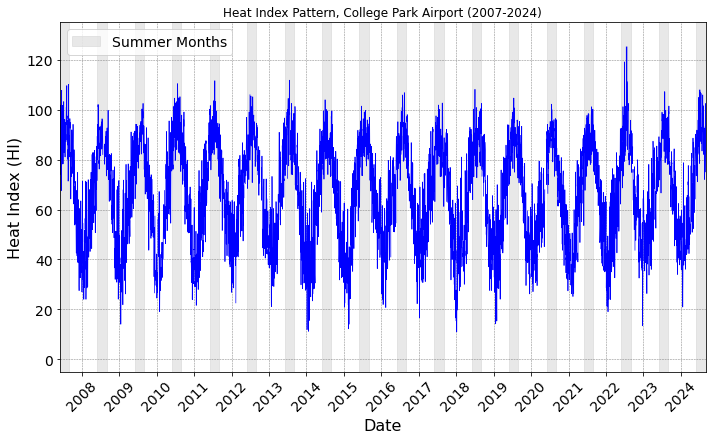

In [69]:
# Example: Plot
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as mpatches

# Create scatter plot
plt.figure(figsize=(10, 6))

# Shade the summers
for year in range(2007, 2025):
    start_summer = pd.to_datetime(f'{year}-06-01') 
    end_summer = pd.to_datetime(f'{year}-08-31')
    plt.axvspan(start_summer, end_summer, color='lightgray', alpha=0.5)
    
# Add a legend for the summer shading
summer_patch = mpatches.Patch(color='lightgray', alpha=0.5, label='Summer Months')
plt.legend(handles=[summer_patch], fontsize=14, loc='upper left')

# Plot the Data
plt.plot(dfHI['date'], dfHI['HI_SLS'], color='b', lw = 0.7, alpha=1)

# Format the Plot
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=1)
#plt.title('Heat Index Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=16)
plt.ylabel('Heat Index (HI)', fontsize=16)

# Format x and y-axis
plt.xticks(rotation=45, fontsize=14)
plt.locator_params(axis='x', nbins=10)  # Adjust number of ticks
plt.yticks(fontsize=14)
plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))  # Yearly
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# X and Y Limits
plt.ylim(-5,135)
plt.xlim(pd.to_datetime('06/01/2007'), pd.to_datetime('08/30/2024'))
plt.tight_layout()

# IF YOU WANT TO SAVE THE FIGURE, USE THIS COMMAND!
#plt.savefig('path/to/your/file', dpi=300)
plt.title('Heat Index Pattern, College Park Airport (2007-2024)')
plt.savefig('Downloads/HI_pattern_CPAirport_lineplot.png', dpi=300)

# Show Plot
plt.show()

C:\Users\slsmit34\AppData\Local\Temp\1\ipykernel_38928\1379956750.py:61: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.AutoDateLocator'>
  plt.locator_params(axis='x', nbins=10)  # Adjust number of ticks


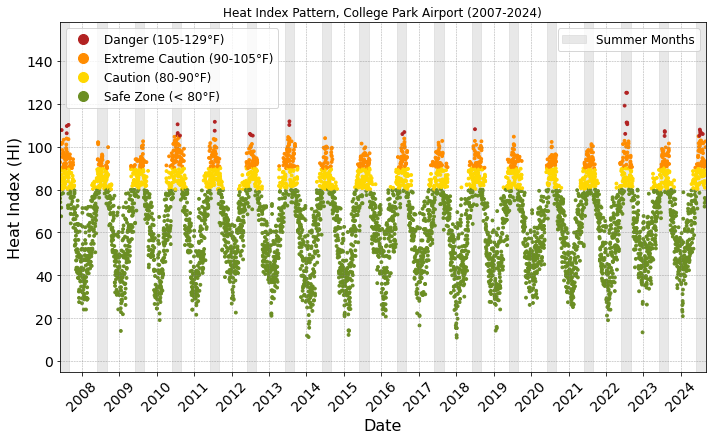

In [71]:
# Example: Plot
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.lines import Line2D

# Create scatter plot
plt.figure(figsize=(10, 6))

#Assign Colors
def get_hi_color(hi):
    if hi >= 130:
        return 'darkmagenta'  # Extreme Danger
    elif 105 <= hi < 130:
        return 'firebrick'      # Danger
    elif 90 <= hi < 105:
        return 'darkorange'   # Extreme Caution
    elif 80 <= hi < 90:
        return 'gold'   # Caution
    else:
        return 'olivedrab'    # Safe Zone or below caution level

# Assign colors based on the HI values
dfHI['color'] = dfHI['HI_SLS'].apply(get_hi_color)


# Shade the summers
for year in range(2007, 2025):
    start_summer = pd.to_datetime(f'{year}-06-01') 
    end_summer = pd.to_datetime(f'{year}-08-31')
    plt.axvspan(start_summer, end_summer, color='lightgray', alpha=0.5)
    
    
# Add a legend for the summer shading and categories
summer_patch = mpatches.Patch(color='lightgray', alpha=0.5, label='Summer Months')
#extreme_danger_patch = mpatches.Patch(color='darkred', label='Extreme Danger (>= 130°F)')
danger_patch = Line2D([], [], marker='o', color='firebrick', markersize=10, label='Danger (105-129°F)', linestyle='None')
extreme_caution_patch = Line2D([], [], marker='o', color='darkorange', markersize=10, label='Extreme Caution (90-105°F)', linestyle='None')
caution_patch = Line2D([], [], marker='o', color='gold', markersize=10, label='Caution (80-90°F)', linestyle='None')
safe_patch = Line2D([], [], marker='o', color='olivedrab', markersize=10, label='Safe Zone (< 80°F)', linestyle='None')

# Add the legend
legend1 = plt.legend(handles=[danger_patch, 
                    extreme_caution_patch, caution_patch, safe_patch], 
           fontsize=12, loc='upper left')

legend2 = plt.legend(handles=[summer_patch], 
           fontsize=12, loc='upper right')

plt.gca().add_artist(legend1)
# Add Data
plt.scatter(dfHI['date'], dfHI['HI_SLS'], color=dfHI['color'], alpha=1, s=8)

# Format Plot
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
#plt.title('Heat Index Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=16)
plt.ylabel('Heat Index (HI)', fontsize=16)

# Format x and yaxis
plt.xticks(rotation=45, fontsize=14)
plt.locator_params(axis='x', nbins=10)  # Adjust number of ticks
plt.yticks(fontsize=14)
plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))  # Yearly
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# X and Y limits
plt.ylim(-5,158)
plt.xlim(pd.to_datetime('06/01/2007'), pd.to_datetime('08/30/2024'))
plt.tight_layout()

# IF YOU WANT TO SAVE THE FIGURE, USE THIS COMMAND!
#
plt.title('Heat Index Pattern, College Park Airport (2007-2024)')
plt.savefig('Downloads/HI_pattern_CPAirport_scatterplot.png', dpi=300)
# Show Plot
plt.show()